# Brexit Polarity Tweets - Deep Learning

## Setup

In [17]:
import re
import os
import nltk
import string
import pickle

# Data Manipulation and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML Tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D, Dropout
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, MaxPooling1D, SimpleRNN

In [25]:
# path to data
PATH_DATA         = "./data/"

# paths to train-test data
PATH_TRAIN_TWEETS_TOKEN = PATH_DATA + "splits/train_tweets_token.csv"
PATH_TEST_TWEETS_TOKEN = PATH_DATA + "splits/test_tweets_token.csv"

PATH_TRAIN_TARGETS      = PATH_DATA + "splits/train_targets.csv"
PATH_TEST_TARGETS      = PATH_DATA + "splits/test_targets.csv"

# paths to model checkpoints
PATH_MODEL_1      = "./model/model_1/"
PATH_MODEL_2      = "./model/model_2/"

# settings
VAL_SPLIT      = 0.10
VOCAB_SIZE     = 30_000
EMBEDDING_DIMS = 200
SEQ_LENGTH     = 100
OOV_LENGTH     = 1

# Data Preparation

In [3]:
from ast import literal_eval

X_train = pd.read_csv(PATH_TRAIN_TWEETS_TOKEN, index_col = False)["Hit Sentence"]
X_test  = pd.read_csv(PATH_TEST_TWEETS_TOKEN, index_col = False)["Hit Sentence"]

X_train = X_train.map(literal_eval).map(lambda tokens: " ".join(tokens))
X_test  = X_test.map(literal_eval).map(lambda tokens: " ".join(tokens))

In [4]:
label_encoder = LabelEncoder()

y_train = pd.read_csv(PATH_TRAIN_TARGETS)["0"]
y_test  = pd.read_csv(PATH_TEST_TARGETS)["0"]

y_train = label_encoder.fit_transform(y_train)
y_test  = label_encoder.transform(y_test)

In [5]:
# split dataset train dataset
partial_X_train, X_val, partial_y_train, y_val = train_test_split(
    X_train, y_train, test_size = VAL_SPLIT, random_state = 123
)

print(f"There are {len(partial_X_train)} tweets in the train dataset.")
print(f"There are {len(X_val)} tweets in the validation dataset.")

There are 257060 tweets in the train dataset.
There are 28563 tweets in the validation dataset.


In [6]:
fd = nltk.FreqDist()
for token_list in X_train:
    for token in token_list.split(" "):
        fd[token] += 1

vocab   = [token for token, count in fd.most_common(VOCAB_SIZE)]
values  = range(2, len(vocab) + 2)

init = tf.lookup.KeyValueTensorInitializer(vocab,
                                           values,
                                           key_dtype = tf.string,
                                           value_dtype = tf.int64)

vocab_table = tf.lookup.StaticVocabularyTable(init, OOV_LENGTH)

In [7]:
preprocess = TextVectorization(max_tokens = VOCAB_SIZE + 2,
                               output_sequence_length = SEQ_LENGTH,
                               output_mode = 'int',
                               vocabulary  = vocab)

In [8]:
partial_X_train = preprocess(partial_X_train)
X_val   = preprocess(X_val)
X_train = preprocess(X_train)
X_test  = preprocess(X_test)

# Hyperparameter Tuning

In [9]:
model = tf.keras.models.Sequential([
    Embedding(VOCAB_SIZE + 2, EMBEDDING_DIMS // 2, input_shape = (SEQ_LENGTH,)),
    GlobalAveragePooling1D(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation = "sigmoid")
])

model.compile(optimizer = 'adam', loss = "BinaryCrossentropy", metrics = ['accuracy'])

In [ ]:
history = model.fit(partial_X_train, 
                    partial_y_train, 
                    validation_data = (X_val, y_val), 
                    epochs = 15, 
                    verbose = 1)

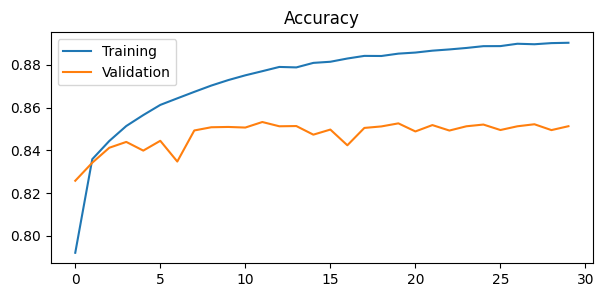

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.figure(figsize = (7, 3))

plt.plot(acc, label = "Training")
plt.plot(val_acc, label = "Validation")
plt.title("Accuracy")
plt.legend()
plt.show()

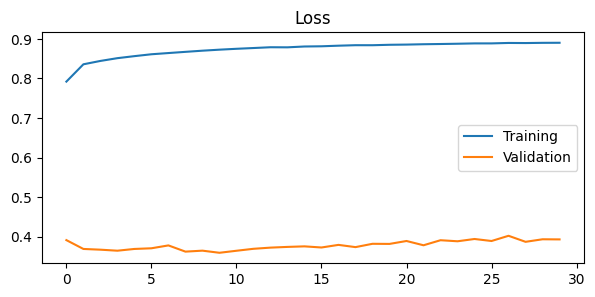

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize = (7, 3))

plt.plot(acc, label = "Training")
plt.plot(val_loss, label = "Validation")
plt.title("Loss")
plt.legend()
plt.show()

# Final Model Training

In [11]:
embedding_layer = Embedding(VOCAB_SIZE + 2,
                            EMBEDDING_DIMS,
                            input_shape = (SEQ_LENGTH,),
                            name="embedding")

In [12]:
model_1 = tf.keras.models.Sequential([
    embedding_layer,
    GlobalAveragePooling1D(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation = "sigmoid")
])

model_1.compile(optimizer = 'adam', loss = "BinaryCrossentropy", metrics = ['accuracy'])

In [22]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 200)          6000400   
                                                                 
 global_average_pooling1d_1   (None, 200)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               25728     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                      

In [13]:
history = model_1.fit(X_train, y_train, epochs = 7, verbose = 1)

Epoch 1/7
8926/8926 [==============================] - 65s 7ms/step - loss: 0.4153 - accuracy: 0.8069
Epoch 2/7
8926/8926 [==============================] - 64s 7ms/step - loss: 0.3496 - accuracy: 0.8434
Epoch 3/7
8926/8926 [==============================] - 64s 7ms/step - loss: 0.3256 - accuracy: 0.8555
Epoch 4/7
8926/8926 [==============================] - 64s 7ms/step - loss: 0.3063 - accuracy: 0.8659
Epoch 5/7
8926/8926 [==============================] - 64s 7ms/step - loss: 0.2909 - accuracy: 0.8745
Epoch 6/7
8926/8926 [==============================] - 63s 7ms/step - loss: 0.2782 - accuracy: 0.8809
Epoch 7/7
8926/8926 [==============================] - 62s 7ms/step - loss: 0.2663 - accuracy: 0.8866


In [26]:
model_1.save(PATH_MODEL_1)
model_1.save(PATH_MODEL_1 + "model.keras")
model_1.save(PATH_MODEL_1 + "model.h5")

INFO:tensorflow:Assets written to: ./model/model_1/assets


In [14]:
model_1.evaluate(X_test, y_test)

2232/2232 [==============================] - 4s 2ms/step - loss: 0.3509 - accuracy: 0.8551


[0.3509155213832855, 0.8550541996955872]

# More Complex Model

In [20]:
regularizer = tf.keras.regularizers.l2(0.0001)
optimizer   = tf.keras.optimizers.Adam(learning_rate = 0.0005)

model_2 = Sequential([
        embedding_layer,
        Conv1D(filters = 64, kernel_size = 3, padding = "causal", activation = "relu"),
        Dropout(0.4),
        MaxPooling1D(pool_size = 2),
        Conv1D(filters = 216, kernel_size = 3, padding = "causal", activation = "relu"),
        Dropout(0.4),
        MaxPooling1D(pool_size = 2),
        SimpleRNN(128, activation = "relu", 
                  kernel_regularizer = regularizer, 
                  recurrent_regularizer = regularizer),
        Dropout(0.4),
        Dense(512, activation='relu', kernel_regularizer = regularizer),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
])

model_2.compile(optimizer = optimizer, loss = "BinaryCrossentropy", metrics = ['accuracy'])

In [23]:
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 200)          6000400   
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 64)           38464     
                                                                 
 dropout_9 (Dropout)         (None, 100, 64)           0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 50, 64)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 50, 216)           41688     
                                                                 
 dropout_10 (Dropout)        (None, 50, 216)           0         
                                                      

In [21]:
model_2.fit(X_train, y_train, epochs = 7, verbose = 1)

Epoch 1/7
8926/8926 [==============================] - 297s 33ms/step - loss: 0.3548 - accuracy: 0.8531
Epoch 2/7
8926/8926 [==============================] - 313s 35ms/step - loss: 0.3121 - accuracy: 0.8709
Epoch 3/7
8926/8926 [==============================] - 789s 88ms/step - loss: 0.2917 - accuracy: 0.8838
Epoch 4/7
8926/8926 [==============================] - 294s 33ms/step - loss: 0.2785 - accuracy: 0.8902
Epoch 5/7
8926/8926 [==============================] - 292s 33ms/step - loss: 0.2672 - accuracy: 0.8958
Epoch 6/7
8926/8926 [==============================] - 295s 33ms/step - loss: 0.2565 - accuracy: 0.9013
Epoch 7/7
8926/8926 [==============================] - 300s 34ms/step - loss: 0.2469 - accuracy: 0.9056


In [27]:
model_2.save(PATH_MODEL_2)
model_2.save(PATH_MODEL_2 + "model.keras")
model_2.save(PATH_MODEL_2 + "model.h5")

INFO:tensorflow:Assets written to: ./model/model_2/assets


INFO:tensorflow:Assets written to: ./model/model_2/assets


In [24]:
model_2.evaluate(X_test, y_test)

2232/2232 [==============================] - 14s 6ms/step - loss: 0.3521 - accuracy: 0.8619


[0.3521104156970978, 0.8618883490562439]